In [1]:
%matplotlib inline
from pyqubo import Array, Placeholder, Constraint
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

## Traveling Salesman Problem (TSP)

Find the shortest route that visits each city and returns to the origin city.

In [15]:
def plot_city(cities, sol=None):
    n_city = len(cities)
    cities_dict = dict(cities)
    G = nx.Graph()
    for city in cities_dict:
        G.add_node(city)
        
    # draw path
    if sol:
        city_order = []
        for i in range(n_city):
            for j in range(n_city):
                if sol.array('c', (i, j)) == 1:
                    city_order.append(j)
        for i in range(n_city):
            city_index1 = city_order[i]
            city_index2 = city_order[(i+1) % n_city]
            G.add_edge(cities[city_index1][0], cities[city_index2][0])

    plt.figure(figsize=(3,3))
    pos = nx.spring_layout(G)
    nx.draw_networkx(G, cities_dict)
    plt.axis("off")
    plt.show()

def dist(i, j, cities):
    pos_i = cities[i][1]
    pos_j = cities[j][1]
    return np.sqrt((pos_i[0] - pos_j[0])**2 + (pos_i[1] - pos_j[1])**2)

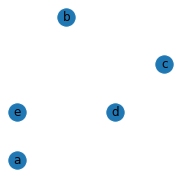

In [16]:
# City names and coordinates list[("name", (x, y))]
cities = [
    ("a", (0, 0)),
    ("b", (1, 3)),
    ("c", (3, 2)),
    ("d", (2, 1)),
    ("e", (0, 1))
]
plot_city(cities)

Prepare binary vector with  bit $(i, j)$ representing to visit $j$ city at time $i$ 

In [4]:
n_city = len(cities)
x = Array.create('c', (n_city, n_city), 'BINARY')

In [5]:
# Constraint not to visit more than two cities at the same time.
time_const = 0.0
for i in range(n_city):
    # If you wrap the hamiltonian by Const(...), this part is recognized as constraint
    time_const += Constraint((sum(x[i, j] for j in range(n_city)) - 1)**2, label="time{}".format(i))

# Constraint not to visit the same city more than twice.
city_const = 0.0
for j in range(n_city):
    city_const += Constraint((sum(x[i, j] for i in range(n_city)) - 1)**2, label="city{}".format(j))

In [6]:
# distance of route
distance = 0.0
for i in range(n_city):
    for j in range(n_city):
        for k in range(n_city):
            d_ij = dist(i, j, cities)
            distance += d_ij * x[k, i] * x[(k+1)%n_city, j]

In [7]:
# Construct hamiltonian
A = Placeholder("A")
H = distance + A * (time_const + city_const)

In [8]:
# Compile model
model = H.compile()

In [9]:
# Generate QUBO
feed_dict = {'A': 4.0}
bqm = model.to_bqm(feed_dict=feed_dict)

In [18]:
import neal
sa = neal.SimulatedAnnealingSampler()
sampleset = sa.sample(bqm, num_reads=100, num_sweeps=100)

# Decode solution
decoded_samples = model.decode_sampleset(sampleset, feed_dict=feed_dict)
best_sample = min(decoded_samples, key=lambda x: x.energy)
num_broken = len(best_sample.constraints(only_broken=True))
print("number of broken constarint = {}".format(num_broken))

number of broken constarint = 0


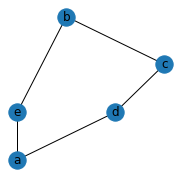

In [19]:
if num_broken == 0:
    plot_city(cities, best_sample)